# 질의 응답 과제

## 과제 소개
- 질의 응답(Question Answering)이란 질문(question)에 답(answer)을 하는 과제
- 질의 응답 과제의 유형은 다양
- 다음 과제에서 진행하는 질의 응답 과제는 질문에 대한 답을 지문(context)에서 찾는 것.
> - __지문(context)__: 한글은 홀소리와 닿소리 모두 소리틀을 본떠 만든 음소문자로 한글 맞춤법에서는 닿소리 14개와 홀소리 10개, 모두 24개를 표준으로 삼는다. “나랏말이 중국과 달라” 문제를 느낀 조선의 세종대왕이 한국어는 물론 이웃나라 말까지 나타내도록 1443년 창제하여 1446년 반포하였다.
 - __질문(question)__: 한글이 창제된 연도는?
 -__답변(answer)__: 1443년

- 형태의 질의 응답 과제에서 모델의 입력은 지문과 질문, 출력은 지문의 각 토큰이 [정답의 시작일 확률, 정답의 끝일 확률]인 형태.
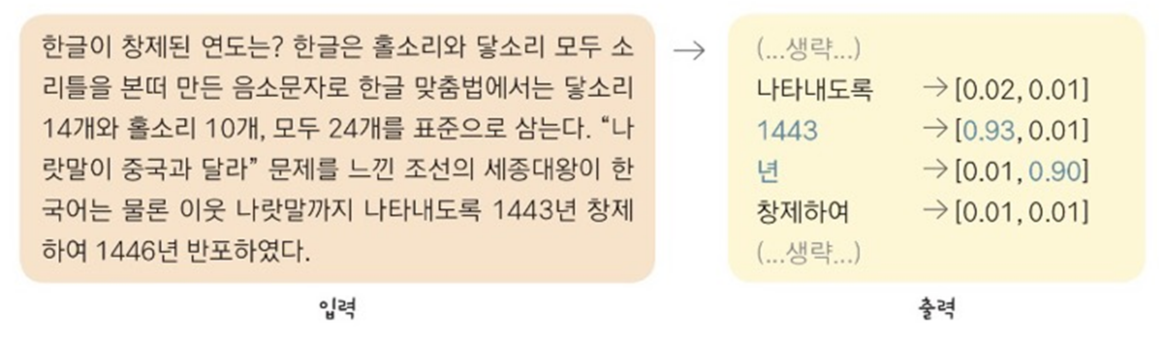

- `나타내도록`의 경우 ‘정답의 시작일 확률(0.02)’과 ‘정답의 끝일 확률(0.01)’의 합이 1이 아니다. 여기서 정답의 시작/끝일 확률은 전체 토큰에 걸쳐 계산
     - 정답의 시작과 관련된 확률 분포는 […, 0.02, 0.93, 0.01, 0.01, …]이며 […, 나타내도록, 1443, 년, 창제하여, …]에 각각 대응
     - 정답의 끝과 관련된 확률 분포는 […, 0.01, 0.01, 0.90, 0.01, …]이며 […, 나타내도록, 1443, 년, 창제하여, …]에 각각 대응

- 질의 응답 모델의 이러한 출력 확률을 적당한 후처리(post processing) 과정을 거쳐 사람이 보기에 좋은 형태로 가공
- 정답의 시작 확률 분포에서 가장 큰 확률값을 가진 토큰부터, 정답의 끝 확률 분포에서 가장 큰 확률값을 가진 토큰까지 이어붙이면 된다.

- 질의 응답 튜토리얼에서는 LG CNS가 공개한 [KorQuAD 1.0](https://korquad.github.io/KorQuad%201.0/)데이터를 활용

## 모델 구조
- 해당 과제에서 사용하는 질의 응답 모델은 다음 그림과 같은 구조.
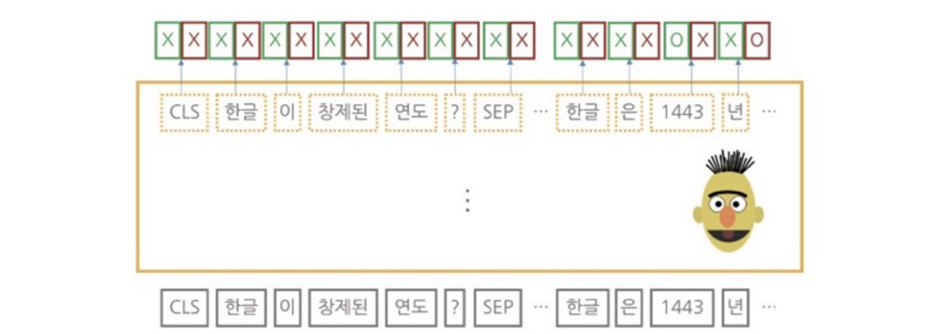

- 질문과 지문을 각각 토큰화한 뒤 `[CLS] + 질문 + [SEP] + 지문 + [SEP]` 형태로 이어 붙인다.
    - `CLS`: 문장 시작을 알리는 스페셜 토큰
    - `SEP`: 질문과 지문을 서로 구분해주는 의미의 스페셜 토큰
- `[CLS] + 질문 + [SEP] + 지문 + [SEP]`를 BERT 모델에 입력하고 모든 입력 토큰에 대해 BERT 모델 마지막 레이어 출력된 토큰 벡터 값에 작은 추가 모듈을 덧붙여 모델의 출력이 ‘해당 지문 토큰이 정답의 시작/끝일 확률’이 되도록 한다.

## 태스크 모듈
- 다음 그림은 질의 응답 모델에 붙는 모듈의 구조이다.
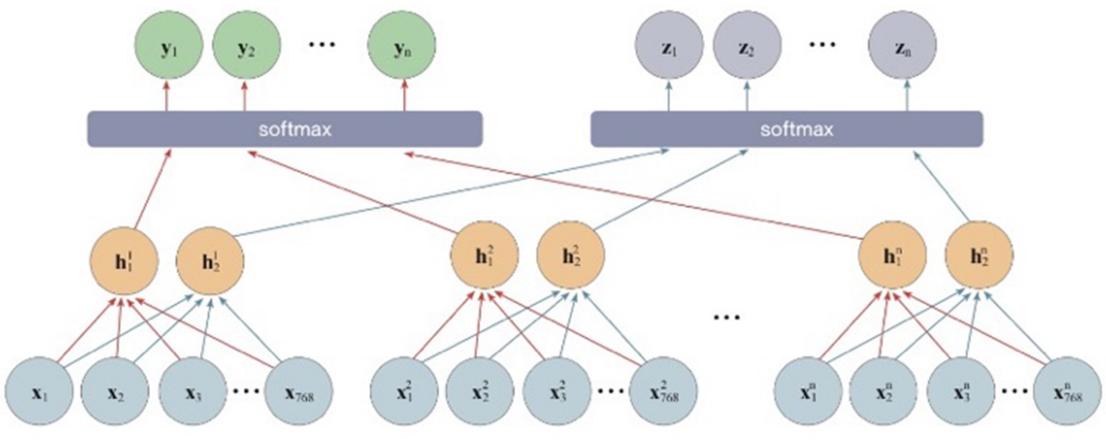

- 마지막 레이어의 개별 토큰 벡터(x) 각각에 드롭아웃(dropout)을 적용.
- 가중치 행렬(weight matrix)을 곱해줘 2차원 벡터(h)로 변환.
    - 2차원으로 사영(projection)하는 이유는 각각이 정답의 시작이냐 아니냐, 정답의 끝이냐 아니냐 정보를 나타낸다.
- 만일 마지막 레이어의 개별 토큰 벡터가 768차원이라면 가중치 행렬 크기는 768  ×  2가 된다.
- 이후 h의 첫번째 값들만 모아서 소프트맥스(softmax)를 취해준 것( y )이 정답의 시작과 관련한 모델의 출력.
- h의 두번째 값들만 모아서 소프트맥스를 취해준 것은 정답의 끝과 관련한 모델의 출력z 
- 입력 토큰 갯수가 $n$개라면  $y$, $z$ 모두 그 차원 수는  $n$이 된다.

## 실습환경 구성
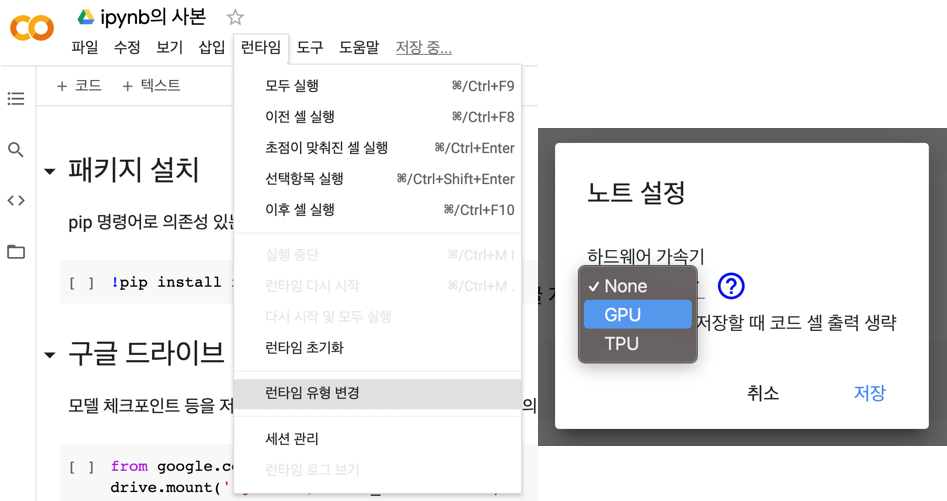

코랩 세션 유지
```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

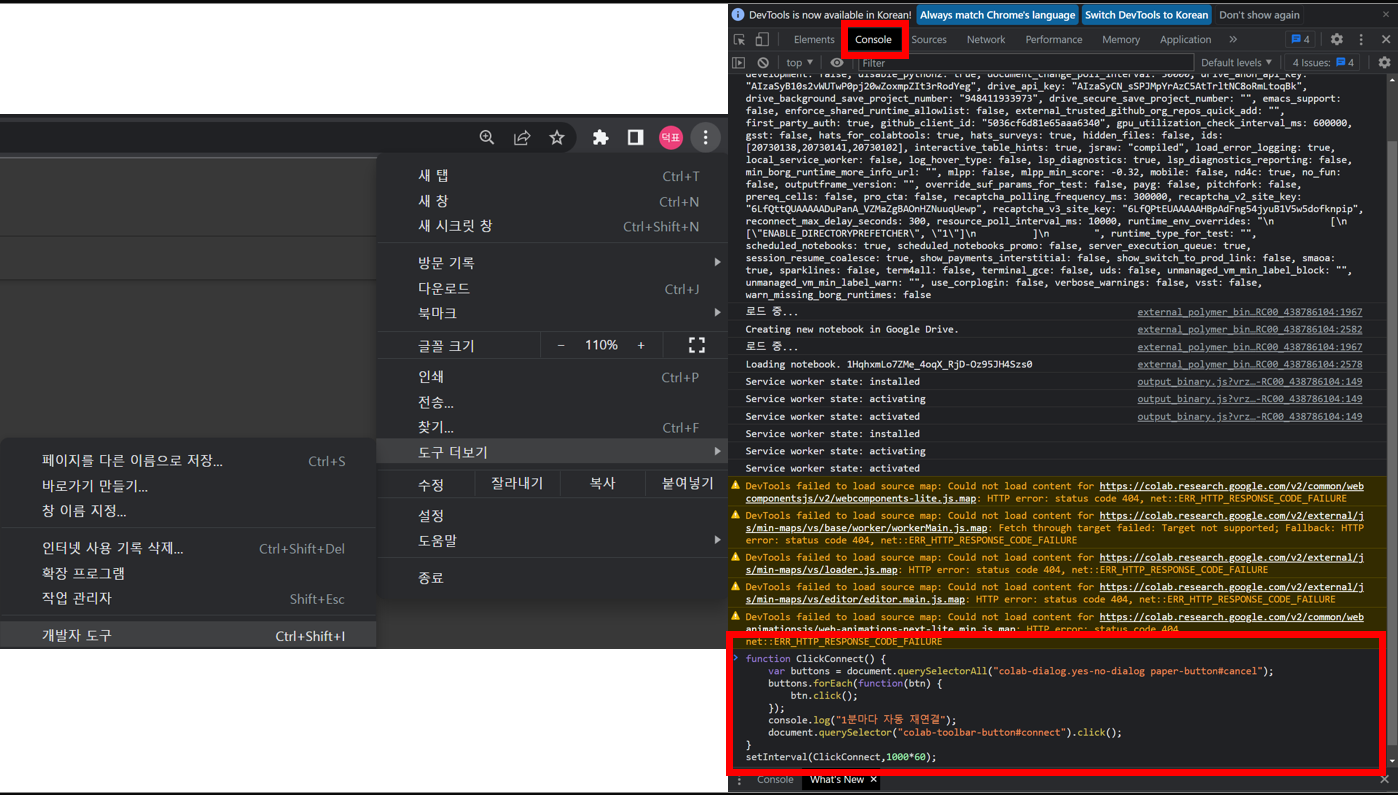

## 추가 라이브러리 설치

In [1]:
!pip install ratsnlp

     |████████████████████████████████| 42 kB 674 kB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 806 kB 18.5 MB/s 
     |████████████████████████████████| 2.8 MB 46.4 MB/s 
     |████████████████████████████████| 136 kB 56.3 MB/s 
     |████████████████████████████████| 398 kB 49.6 MB/s 
     |████████████████████████████████| 829 kB 51.0 MB/s 
     |████████████████████████████████| 636 kB 46.5 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 3.3 MB 50.5 MB/s 
     |████████████████████████████████| 895 kB 51.9 MB/s 
     |████████████████████████████████| 1.1 MB 49.8 MB/s 
     |████████████████████████████████| 96 kB 5.2 MB/s 
     |████████████████████████████████| 144 kB 53.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 57.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sh

## 구글드라이브와 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##  KorQuAD 1.0 데이터 다운로드

In [3]:
!mkdir /content/Korpora
!mkdir /content/Korpora/korquad-v1/
!wget -O /content/Korpora/korquad-v1/KorQuAD_v1.0_train.json https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
!wget -O /content/Korpora/korquad-v1/KorQuAD_v1.0_dev.json https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json

--2022-04-12 06:18:16--  https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
Resolving korquad.github.io (korquad.github.io)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38527475 (37M) [application/json]
Saving to: ‘/content/Korpora/korquad-v1/KorQuAD_v1.0_train.json’

/content/Korpora/ko 100%[===================>]  36.74M   234MB/s    in 0.2s    

2022-04-12 06:18:16 (234 MB/s) - ‘/content/Korpora/korquad-v1/KorQuAD_v1.0_train.json’ saved [38527475/38527475]

--2022-04-12 06:18:16--  https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json
Resolving korquad.github.io (korquad.github.io)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3881058 (3.7M) [application/json]
Saving to: 

## 모델 환경 설정

In [4]:
import torch
from ratsnlp.nlpbook.qa import QATrainArguments
args = QATrainArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_corpus_name="korquad-v1",
    downstream_model_dir="/content/drive/MyDrive/nlpbook/checkpoint-qa",
    max_seq_length=128,
    max_query_length=32,
    doc_stride=64,
    batch_size=32,
    learning_rate=5e-5,
    epochs=1,
    tpu_cores=0,
    seed=7,
)

```
- pretrained_model_name : 프리트레인 마친 언어모델의 이름
- downstream_corpus_name : 다운스트림 데이터의 이름.
- downstream_model_dir : 파인튜닝된 모델의 체크포인트가 저장될 위치. 
- max_seq_length : 토큰 기준 입력 문장 최대 길이(지문, 질문 모두 포함).
- max_query_length : 토큰 기준 질문 최대 길이.
- doc_stride : 지문(context)에서 몇 개 토큰을 슬라이딩해가면서 데이터를 불릴지 결정.
- batch_size : 배치 크기. 하드웨어 가속기로 GPU를 선택했다면 32, TPU라면 4. 
- learning_rate : 러닝레이트. 1회 스텝에서 한 번에 얼마나 업데이트할지에 관한 크기를 가리킵니다.
- epochs : 학습 에폭 수. 
- tpu_cores : TPU 코어 수. 하드웨어 가속기로 GPU를 선택했다면 0, TPU라면 8.
- seed : 랜덤 시드(정수, integer). None을 입력하면 랜덤 시드를 고정하지 않습니다.
```

### 랜덤 시드 고정

In [5]:
from ratsnlp import nlpbook
nlpbook.set_seed(args)

set seed: 7


### 로거 설정
- 각종 로그들을 출력하는 로거를 설정

In [6]:
nlpbook.set_logger(args)

INFO:ratsnlp:Training/evaluation parameters QATrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_corpus_name='korquad-v1', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/content/drive/MyDrive/nlpbook/checkpoint-qa', max_seq_length=128, doc_stride=64, max_query_length=32, threads=4, cpu_workers=4, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=1, batch_size=32, fp16=False, tpu_cores=0, tqdm_enabled=True)


## 토크나이저 준비하기
- 이준범 님이 공개하신 kcbert-base 모델이 사용하는 토크나이저를 선언

In [7]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    "beomi/kcbert-base",
    do_lower_case=False,
)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

In [ ]:
import json

json.load(open('/content/Korpora/korquad-v1/KorQuAD_v1.0_dev.json', 
               "r", encoding="utf-8"))["data"][0]['paragraphs'][0:2]

[{'context': '1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.',
  'qas': [{'answers': [{'answer_start': 0, 'text': '1989년 2월 15일'}],
    'id': '6548850-0-0',
    'question': '임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?'},
   {'answers': [{'answer_start': 125, 'text': '임수경'}],
    'id': '6548850-0-1',
    'question': '1989년 6월 30일 평양축전에 대표로 파견 된 인물은?'},
   {'answers': [{'answer_start': 0, 'text': '1989년'}],
    'id': '6548853-0-0',
    'question': '임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?'},
   {'answers': [{'answer_start': 365, 'text': '학생회관 건물 계단'}],
    'id': '6548853-0-

In [8]:
from ratsnlp.nlpbook.qa import KorQuADV1Corpus, QADataset
corpus = KorQuADV1Corpus()
train_dataset = QADataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="train",
)

INFO:ratsnlp:Creating features from train dataset file at /content/Korpora/korquad-v1
convert squad examples to features: 100%|██████████| 57688/57688 [03:42<00:00, 258.76it/s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:question & context: [CLS] 바 ##그 ##너 ##는 괴 ##테 ##의 파 ##우스 ##트를 읽고 무엇을 쓰고 ##자 했 ##는가 ? [SEP] 18 ##3 ##9년 바 ##그 ##너 ##는 괴 ##테 ##의 파 ##우스 ##트 ##을 처음 읽고 그 내용 ##에 마음이 끌려 이를 소재 ##로 해서 하나의 교 ##향 ##곡 ##을 쓰 ##려는 뜻을 갖 ##는다 . 이 시기 바 ##그 ##너 ##는 18 ##3 ##8년 ##에 빛 독 ##촉 ##으로 산 ##전 ##수 ##전을 다 걲 ##은 상황이 ##라 좌 ##절 ##과 실망 ##에 가득 ##했 ##으며 메 ##피 ##스 ##토 ##펠 ##레스 ##를 만나는 파 ##우스 ##트 ##의 심 ##경 ##에 공감 ##했다고 한다 . 또한 파리 ##에서 아 ##브 ##네 ##크 ##의 지휘 ##로 파리 음악 ##원 관 ##현 ##악 ##단이 연 ##주 ##하는 베 ##토 [SEP]
INFO:ratsnlp:answer: 교 ##향 ##곡
INFO:ratsnlp:features: QAFeatures(input_ids=[2, 1480, 4313, 4538, 4008, 336, 4065, 4042, 3231, 23243, 19143, 13985, 12449, 9194, 4105, 3385, 9411, 32, 3, 8601, 4633, 29697, 1480, 4313, 4538, 4008, 336, 4065, 4042, 3231, 23243, 4104, 4027, 8793, 13985, 391, 9132, 4113, 10966

In [10]:
train_dataset[1]

QAFeatures(input_ids=[2, 1480, 4313, 4538, 4008, 336, 4065, 4042, 3231, 23243, 19143, 13985, 12449, 9194, 4105, 3385, 9411, 32, 3, 10958, 4062, 9511, 1355, 4600, 4103, 4775, 5602, 10770, 4180, 26732, 3231, 23243, 4104, 4042, 2015, 4012, 4113, 9198, 8763, 8129, 17, 10384, 23008, 7971, 2170, 4408, 4011, 4147, 4042, 17015, 4091, 23008, 21056, 4165, 323, 4175, 4158, 11413, 2273, 4043, 7966, 1543, 4775, 4170, 4042, 341, 4573, 4771, 28, 4566, 4027, 10599, 18907, 208, 9504, 24835, 15, 11060, 2451, 4780, 4032, 18548, 4113, 3231, 23243, 4104, 4042, 1843, 4771, 7965, 28987, 4153, 2451, 15489, 4113, 13928, 17283, 575, 4261, 26783, 8114, 8852, 9107, 4082, 28498, 8131, 17, 8225, 4042, 1114, 4281, 4194, 17138, 4042, 9961, 8222, 14041, 10892, 4113, 2524, 4443, 8032, 12710, 21602, 18625, 24569, 4136, 3], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## 학습 데이터 로더 구축

In [9]:
from torch.utils.data import DataLoader, RandomSampler
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=RandomSampler(train_dataset, replacement=False),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=4,
)

- `sampler`: 샘플링 방식을 정의  
- `collate_fn`:  인스턴스를 배치로 만드는 역할

## 평가용 데이터 로더 구축

In [11]:
from torch.utils.data import SequentialSampler
val_dataset = QADataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="val",
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    sampler=SequentialSampler(val_dataset),
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=4,
)

INFO:ratsnlp:Creating features from val dataset file at /content/Korpora/korquad-v1
convert squad examples to features: 100%|██████████| 5533/5533 [00:22<00:00, 245.67it/s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:question & context: [CLS] 198 ##9년 6월 30 ##일 평양 ##축 ##전에 대표로 파견 된 인물 ##은 ? [SEP] 198 ##9년 2월 15일 여의도 농민 폭력 시위를 주도 ##한 혐의 ( 폭력 ##행위 ##등 ##처벌 ##에 ##관 ##한 ##법 ##률 ##위반 ) 으로 지명 ##수 ##배 ##되었다 . 198 ##9년 3월 12 ##일 서울 ##지 ##방 ##검찰 ##청 공안 ##부는 임종석 ##의 사전 ##구속 ##영장 ##을 발부 ##받았 ##다 . 같은 해 6월 30 ##일 평양 ##축 ##전에 임 ##수 ##경을 대표로 파견 ##하여 국가보안법 ##위반 혐의가 추가 ##되었다 . 경찰은 12월 18 ##일 ~ 20 ##일 사이 서울 경 ##희 ##대학 ##교 ##에서 임종석 ##이 성 ##명 발표 ##를 추진 ##하고 있다는 첩 ##보를 입 ##수 ##했고 , 12월 18 ##일 오전 7시 40 ##분 경 가스 ##총 ##과 [SEP]
INFO:ratsnlp:answer: 임 ##수 ##경을
INFO:ratsnlp:features: QAFeatures(input_ids=[2, 25704, 29697, 23343, 8476, 4046, 14601, 4728, 8409, 24345, 20158, 902, 10393, 4057, 32, 3, 25704, 29697, 18163, 26757, 20604, 29804, 10901, 25099, 13225, 4047, 16704, 11, 10901, 12175, 4086, 11417, 4113, 4337

## 모델 불러오기

### 모델 초기화
- `BertForQuestionAnswering`은 프리트레인을 마친 BERT 모델

In [13]:
from transformers import BertConfig, BertForQuestionAnswering
pretrained_model_config = BertConfig.from_pretrained(
    'beomi/kcbert-base',
)
model = BertForQuestionAnswering.from_pretrained(
        'beomi/kcbert-base',
        config=pretrained_model_config,
)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model c

## 모델 학습시키기
- 파이토치 라이트닝(pytorch lightning)이 제공하는 라이트닝(lightning) 모듈을 상속받아 태스크(task)를 정의

In [14]:
from ratsnlp.nlpbook.qa import QATask
task = QATask(model, args)

In [15]:
trainer = nlpbook.get_trainer(args)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory /content/drive/MyDrive/nlpbook/checkpoint-qa exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(
    task,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | model | BertForQuestionAnswering | 108 M 
---------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.318   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# 평가

In [20]:
!pip install -U --no-cache-dir gdown --pre
print("Downloading...")
!gdown --id {"1-IaB1LVZ1c8NscCdKGpGwtc_eGMD2yxt"} -O /content/drive/MyDrive/nlpbook/checkpoint-qa/epoch=0-val_loss=0.46v1.ckpt

Downloading...
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-IaB1LVZ1c8NscCdKGpGwtc_eGMD2yxt 



## 인퍼런스 설정

In [17]:
from ratsnlp.nlpbook.qa import QADeployArguments
args = QADeployArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_model_dir="/content/drive/MyDrive/nlpbook/checkpoint-qa",
    max_seq_length=128,
    max_query_length=32,
)

downstream_model_checkpoint_fpath: /content/drive/MyDrive/nlpbook/checkpoint-qa/epoch=0-val_loss=0.46.ckpt


## 체크포인트 로드

In [18]:
import torch
fine_tuned_model_ckpt = torch.load(
    '/content/drive/MyDrive/nlpbook/checkpoint-qa/epoch=0-val_loss=0.46.ckpt',
    map_location=torch.device("cpu")
)

## BERT 설정, 모델 초기화 진행

In [21]:
from transformers import BertConfig
from transformers import BertForQuestionAnswering

pretrained_model_config = BertConfig.from_pretrained(
    'beomi/kcbert-base',
)

model = BertForQuestionAnswering(pretrained_model_config)

## 모델 체크포인트 읽기

In [22]:
model.load_state_dict({k.replace("model.", ""): v for k, v in \
                       fine_tuned_model_ckpt['state_dict'].items()})

<All keys matched successfully>

## 모델 출력값 만들고 후처리

In [23]:
def inference_fn(question, context):
    if question and context:
        truncated_query = tokenizer.encode(
            question,
            add_special_tokens=False,
            truncation=True,
            max_length=32
       )
        inputs = tokenizer.encode_plus(
            text=truncated_query,
            text_pair=context,
            truncation="only_second",
            padding="max_length",
            max_length=128,
            return_token_type_ids=True,
        )
        with torch.no_grad():
            outputs = model(**{k: torch.tensor([v]) for k, v in inputs.items()})
            start_pred = outputs.start_logits.argmax(dim=-1).item()
            end_pred = outputs.end_logits.argmax(dim=-1).item()
            pred_text = tokenizer.decode(inputs['input_ids']\
                                         [start_pred:end_pred+1])
    else:
        pred_text = ""
    return {
        'question': question,
        'context': context,
        'answer': pred_text,
    }

In [24]:
inference_fn('개통된 년도는 언제인가?','한강대교(漢江大橋)는 서울특별시 용산구 이촌동에 있는 용산구 한강로3가와 동작구 본동 사이를 잇는 총연장 1,005m의 길이의 교량(다리)이다. 한강에 놓인 최초의 도로 교량으로, 제1한강교라고 불렸다. 1917년 개통된 뒤 몇 차례의 수난을 거쳐 지금에 이른다.')

{'answer': '1917년',
 'context': '한강대교(漢江大橋)는 서울특별시 용산구 이촌동에 있는 용산구 한강로3가와 동작구 본동 사이를 잇는 총연장 1,005m의 길이의 교량(다리)이다. 한강에 놓인 최초의 도로 교량으로, 제1한강교라고 불렸다. 1917년 개통된 뒤 몇 차례의 수난을 거쳐 지금에 이른다.',
 'question': '개통된 년도는 언제인가?'}

In [25]:
contxt = '파이썬은 1991년 네덜란드계 프로그래머인 귀도 반 로섬이 발표한 고급 프로그래밍 언어로, 플랫폼에 독립적이며 인터프리터식, 객체지향적, 동적 타이핑(dynamically typed) 대화형 언어이다. 파이썬이라는 이름은 귀도가 좋아하는 코미디 〈Monty Python\'s Flying Circus〉에서 따온 것이다. '
inference_fn('파이썬을 발표한 사람은?', contxt)

{'answer': '귀도 반 로섬',
 'context': "파이썬은 1991년 네덜란드계 프로그래머인 귀도 반 로섬이 발표한 고급 프로그래밍 언어로, 플랫폼에 독립적이며 인터프리터식, 객체지향적, 동적 타이핑(dynamically typed) 대화형 언어이다. 파이썬이라는 이름은 귀도가 좋아하는 코미디 〈Monty Python's Flying Circus〉에서 따온 것이다. ",
 'question': '파이썬을 발표한 사람은?'}

In [26]:
inference_fn('파이썬을 개발한 사람은?', contxt)

{'answer': '[CLS]',
 'context': "파이썬은 1991년 네덜란드계 프로그래머인 귀도 반 로섬이 발표한 고급 프로그래밍 언어로, 플랫폼에 독립적이며 인터프리터식, 객체지향적, 동적 타이핑(dynamically typed) 대화형 언어이다. 파이썬이라는 이름은 귀도가 좋아하는 코미디 〈Monty Python's Flying Circus〉에서 따온 것이다. ",
 'question': '파이썬을 개발한 사람은?'}

## 웹 서비스
```
ngrok은 코랩 로컬에서 실행 중인 웹서비스를 안전하게 외부에서 접근 가능하도록 해주는 도구입니다. 
ngrok을 실행하려면 회원가입 후 로그인을 한 뒤 이곳에 접속해 인증 토큰(authtoken)을 확인해야 합니다. 
예를 들어 확인된 authtoken이 test111이라면 다음과 같이 실행합니다.
!mkdir /root/.ngrok2 && echo "authtoken: test111" > /root/.ngrok2/ngrok.yml
```

In [28]:
!mkdir /root/.ngrok2 && echo "authtoken: 27PXyFB1jwwaI0yhGPYuZLyMPwg_3cHnELJNX6nhc7bsg6qjn" > /root/.ngrok2/ngrok.yml

mkdir: cannot create directory ‘/root/.ngrok2’: File exists


In [29]:
from ratsnlp.nlpbook.qa import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()

 * Serving Flask app "ratsnlp.nlpbook.qa.deploy" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://b626-34-83-217-141.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [12/Apr/2022 08:04:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2022 08:04:48] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [12/Apr/2022 08:04:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2022 08:07:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2022 08:07:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2022 08:08:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2022 08:08:48] "POST /api HTTP/1.1" 200 -
